In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(2)

import statistics

Set-Up

In [2]:
def get_covariance_matrix(n, correlation_len, amp):
    """Generates a 1D Gaussian covariance matrix (Toeplitz)."""
    x = np.arange(n)
    dists = np.abs(x[:, None] - x[None, :])
    return amp**2 * np.exp(-0.5 * (dists / correlation_len)**2)

# Simulation Dimensions
n_scan = 1                  # s = 1
n_time = 32                 # t = 0...n_time-1
n_pix = 32                  # p = 1...n_pix
n_tod = n_time * n_pix
n_atm = n_time + n_pix - 1  # Size of atmospheric strip (wind=1)
sigma_n = 1              # White noise

Covariances Ccmb and Ca

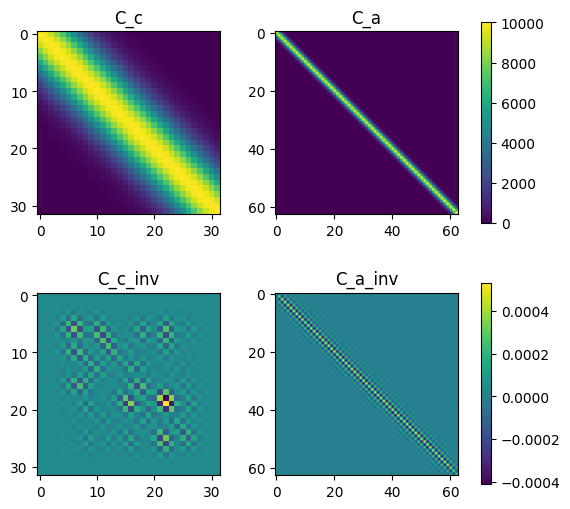

In [3]:
# C_c: CMB Covariance (2x2 matrix)
C_c = get_covariance_matrix(n_pix, correlation_len=5.0, amp=1.0)
C_c_inv = la.inv(C_c)
C_c_pack = np.stack(
    [get_covariance_matrix(n_pix, 1.0, amp=i) for i in range(1, 100)],
    axis=0
)

# C_a: Atmosphere Covariance
C_a = get_covariance_matrix(n_atm, correlation_len=1.0, amp=100.0)
C_a_inv = la.inv(C_a)
C_a_pack = np.stack(
    [get_covariance_matrix(n_atm, 1.0, amp=i) for i in range(1, 100)],
    axis=0
)

# N_s: Instrumental Noise Covariance
N_s = np.eye(n_time * n_pix) * sigma_n**2


fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.3)

# Row 1: Covariance matrices
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(C_c)
ax1.set_title('C_c')
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(C_a)
ax2.set_title('C_a')
plt.colorbar(im2, ax=[ax1, ax2], location='right', fraction=0.046)
# Row 2: Inverse covariance matrices
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.imshow(C_c_inv)
ax3.set_title('C_c_inv')
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(C_a_inv)
ax4.set_title('C_a_inv')
plt.colorbar(im4, ax=[ax3, ax4], location='right', fraction=0.046)
plt.show()

MAP Estimator

In [4]:
def generate_simulation(C_atm, seed=None):
    # change random seeds every time we call
    if seed is not None:
        np.random.seed(seed)

    """Generate one simulation of CMB + Atmosphere + Noise"""
    # Generate Truth from Priors
    # c: Static CMB field
    c_true = np.random.multivariate_normal(mean=np.zeros(n_pix), cov=C_c)
    c_true -= c_true.mean()
    # a_s^0: Atmospheric field at t=0
    a_true = np.random.multivariate_normal(mean=np.zeros(n_atm), cov=C_atm)
    a_true -= a_true.mean()

    # Operators
    # P: Pointing Matrix
    # L_s: Wind advection operator
    P = np.zeros((n_time * n_pix, n_pix))
    L_s = np.zeros((n_time * n_pix, n_atm))

    # Buffer offset: place initial atmosphere in the middle of the buffer
    # This allows the atmosphere to move either direction
    offset = n_time - 1  # Maximum time index, gives us room to move

    # Fill the operators
    for t in range(n_time):
        for p in range(n_pix):
            tod_idx = t * n_pix + p
            
            # Fill P: maps pixel index p to data
            P[tod_idx, p] = 1.0
            
            # Fill L_s: maps atmosphere at (t, p) to data
            # Wind w = +1 (RIGHTWARD). Atmosphere drifts to the right.
            # At time t, detector p sees atmosphere that was at position (p - vt)
            # With v = +1 (rightward), we get: atm_idx = p - t + offset
            atm_idx = p - t + offset
            L_s[tod_idx, atm_idx] = 1.0

    # d_s = P c + L_s a_s^0 + epsilon_s
    CMB_time_series = P @ c_true
    Atmo_time_series = L_s @ a_true
    epsilon_s = np.random.normal(0, sigma_n, n_time * n_pix)
    d_s = CMB_time_series + Atmo_time_series + epsilon_s
    return CMB_time_series, Atmo_time_series, epsilon_s, d_s, a_true, c_true, P, L_s

# CMB_time_series, Atmo_time_series, epsilon_s, d_s, a_true, c_true, P, L_s = generate_simulation()
simulation_list = [
    generate_simulation(C_atm, seed=i)
    for i, C_atm in enumerate(C_a_pack)
]

In [5]:
def estimator(simulation):
    CMB_time_series, Atmo_time_series, epsilon_s, d_s, a_true, c_true, P, L_s = simulation
    # Effective Covariance
    # N_tilde_s = N_s + L_s C_a L_s^T
    N_tilde_s = N_s + L_s @ C_a @ L_s.T
    N_tilde_inv = la.inv(N_tilde_s)

    # Estimator Covariance
    # Cov(c_hat) = (Sum P^T N_tilde^-1 P + C_c^-1)^-1
    inv_cov_posterior = P.T @ N_tilde_inv @ P + C_c_inv
    cov_c_hat = la.inv(inv_cov_posterior)

    # MAP Estimator
    # c_hat = Cov(c_hat) * (Sum P^T N_tilde^-1 d_s)
    weighted_data = P.T @ N_tilde_inv @ d_s
    c_hat = cov_c_hat @ weighted_data

    return (c_true, c_hat)

estimator_pack =  [estimator(simulation) for simulation in simulation_list]

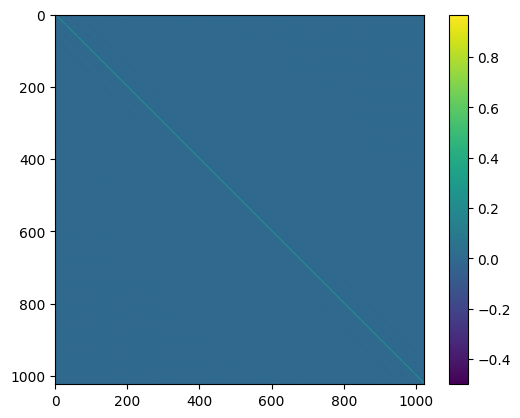

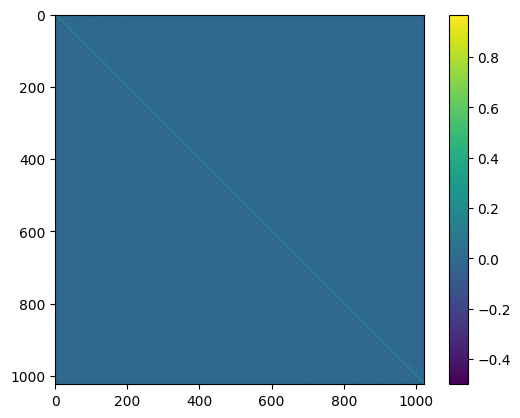

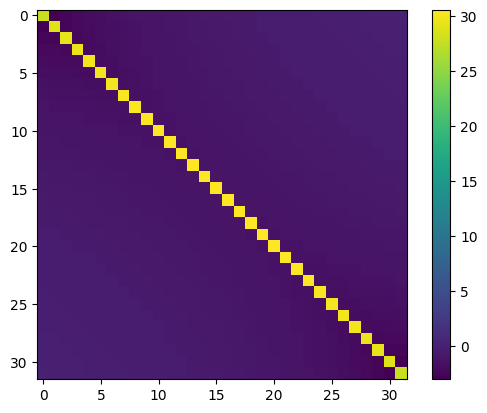

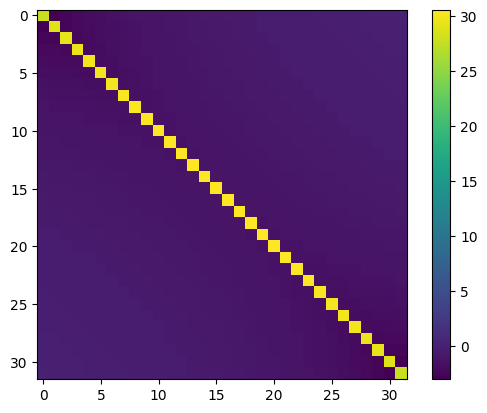

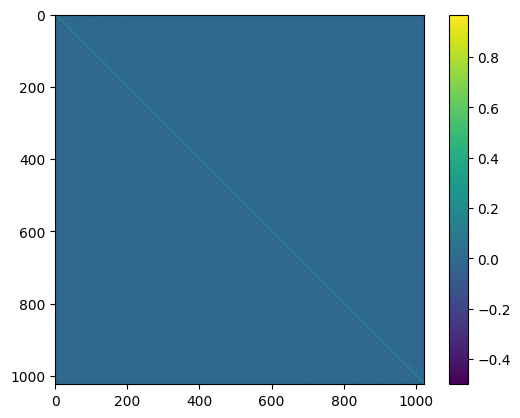

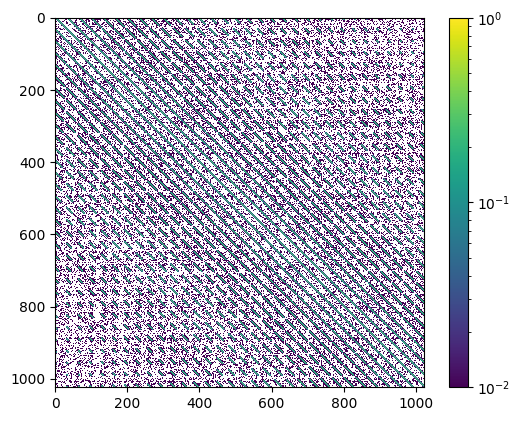

In [6]:
# Example

CMB_time_series, Atmo_time_series, epsilon_s, d_s, a_true, c_true, P, L_s = generate_simulation(C_a)
# Effective Covariance
# N_tilde_s = N_s + L_s C_a L_s^T
N_tilde_s = N_s + L_s @ C_a @ L_s.T
N_tilde_inv = la.inv(N_tilde_s)

# Estimator Covariance
# Cov(c_hat) = (Sum P^T N_tilde^-1 P + C_c^-1)^-1
inv_cov_posterior = P.T @ N_tilde_inv @ P + C_c_inv
cov_c_hat = la.inv(inv_cov_posterior)

# MAP Estimator
# c_hat = Cov(c_hat) * (Sum P^T N_tilde^-1 d_s)
weighted_data = P.T @ N_tilde_inv @ d_s
c_hat = cov_c_hat @ weighted_data

plt.imshow(N_tilde_inv)
plt.colorbar()
plt.show()

Pi = np.eye(len(N_tilde_inv)) - L_s@np.linalg.inv(L_s.T@L_s)@L_s.T
Pi *= sigma_n**2
plt.imshow(Pi)
plt.colorbar()
plt.show()

plt.imshow(P.T @ N_tilde_inv @ P)
plt.colorbar()
plt.show()

plt.imshow(P.T @ Pi @ P)
plt.colorbar()
plt.show()

plt.imshow(np.eye(len(N_tilde_inv)) - L_s@np.linalg.inv(L_s.T@L_s)@L_s.T)
plt.colorbar()
plt.show()

plt.imshow(L_s@L_s.T, norm=plt.matplotlib.colors.LogNorm(vmin=1e-2, vmax=1))
plt.colorbar()
plt.show()

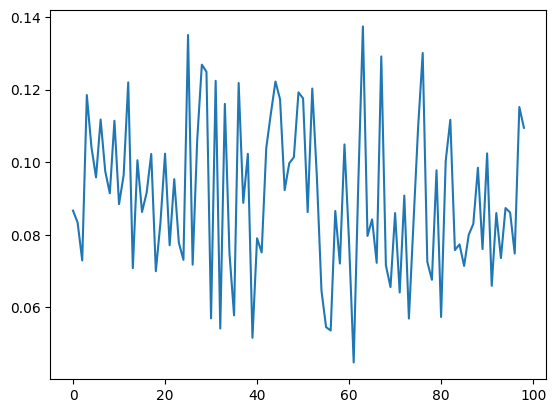

In [7]:
value = [statistics.stdev(b - a) * sigma_n **(-1) for a, b in estimator_pack]

plt.plot(value)

In [8]:
def ML_estimator(simulation):

    ds = simulation[3]
    c_t = simulation[5]
    Pi = simulation[6]
    Ls = simulation[7]

    Pi_a = Ls @ la.inv(Ls.T @ Ls) @ Ls.T
    Pi_a_perp = np.eye(n_time * n_pix) - Pi_a
    c_hat_ML = la.inv(Pi.T @ Pi_a_perp @ Pi) @ Pi.T @ Pi_a_perp @ ds
    return (c_hat_ML, c_t)

ML_estimator_pack = [ML_estimator(simulation) for simulation in simulation_list]

In [9]:
print(np.shape(ML_estimator_pack))

(99, 2, 32)


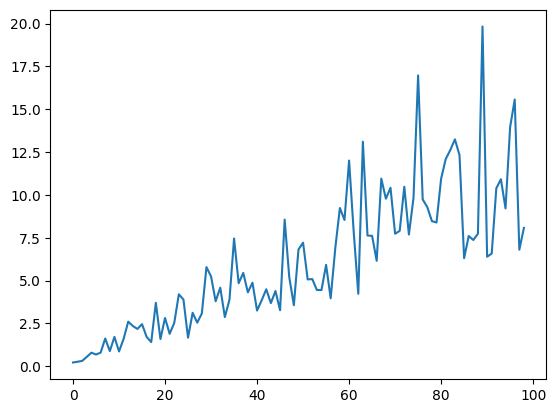

In [10]:
value2 = [statistics.stdev(b - a) * sigma_n **(-1) for a, b in ML_estimator_pack]

plt.plot(value2)